In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

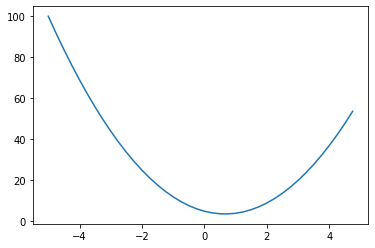

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [346]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  

  def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [64]:
a = Value(2.0)
b = Value(4.0)
a / b
a - b

Value(data=-2.0)

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


Value(data=4.0)

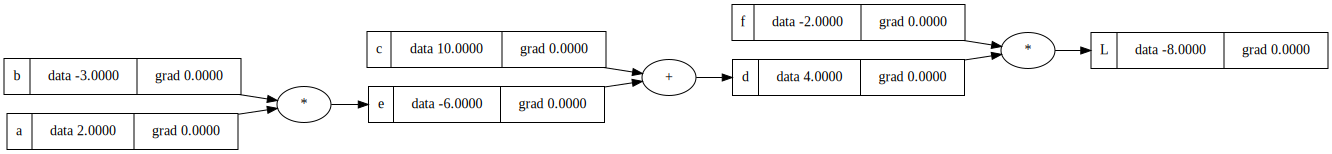

In [10]:
draw_dot(L)

In [11]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-8.0


In [12]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


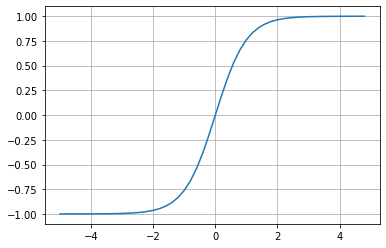

In [13]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

## nn

In [65]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

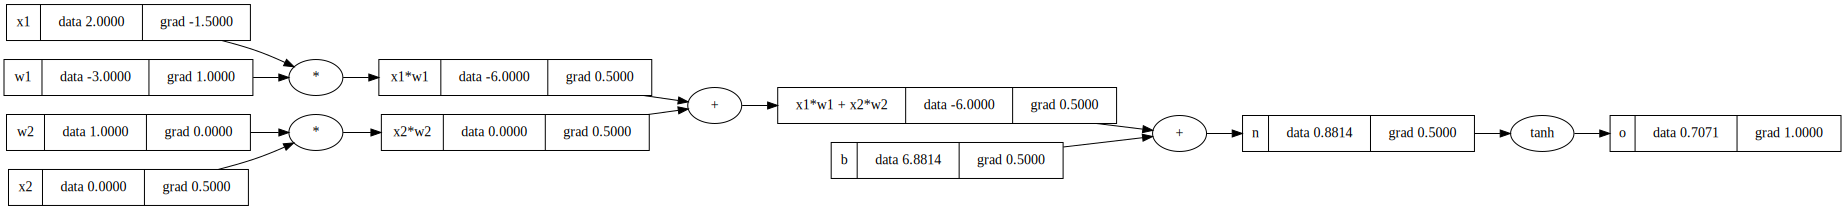

In [66]:
draw_dot(o)

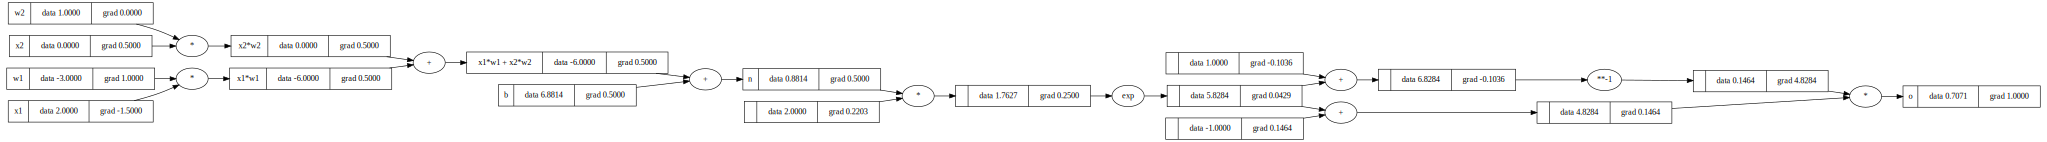

In [68]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


e = (2*n).exp()
o = (e -1) / (e + 1)
o.label ='o'
o.backward()
draw_dot(o)

In [16]:
o.backward()

In [17]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [18]:
o.grad = 1.0

In [19]:
o._backward()

In [20]:
n._backward()

In [21]:
b._backward()

In [22]:
x1w1x2w2._backward()

In [23]:
x2w2._backward()
x1w1._backward()

In [24]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [25]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [26]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [27]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [28]:
n.grad = 0.5

In [29]:
o.grad = 1.0

In [30]:
1 - o.data**2

0.4999999999999999

In [31]:
# o = tanh(n)
# do/dn = 1 - o**2

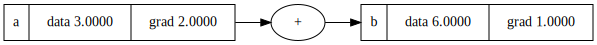

In [32]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

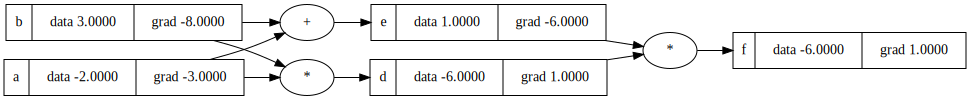

In [33]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

## pytorch version

In [80]:
import torch
import random

In [70]:


x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [72]:
torch.Tensor([2.0])

tensor([2.])

In [74]:
o.item()

0.7071066904050358

In [75]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [78]:
x2.grad.item()

0.5000001283844369

### nn

In [129]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
      return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
#n = Neuron(2)
#n = Layer(2,3)
n = MLP(3,[4,4,1])   # 3 INPUTS 4 HIDDEN LAYERS 4 HIDDEN LAYERS AND LASTLY ONE OUTPUTS
n(x)

Value(data=-0.7466331240847136)

In [130]:
n.parameters()

[Value(data=0.842447238157356),
 Value(data=0.31293641494755664),
 Value(data=-0.9150638518332885),
 Value(data=-0.7587437913733117),
 Value(data=-0.9734505165994776),
 Value(data=0.8421160633826454),
 Value(data=0.6544590678290276),
 Value(data=0.2219725539141082),
 Value(data=-0.7961662244585965),
 Value(data=0.8422099552695299),
 Value(data=-0.2787623450617809),
 Value(data=0.6322960005674834),
 Value(data=0.7240314395847385),
 Value(data=-0.6437450965973535),
 Value(data=-0.6548784286749094),
 Value(data=0.6749233926615441),
 Value(data=0.4434220428595055),
 Value(data=-0.9958113009574148),
 Value(data=-0.705232848310428),
 Value(data=0.508130772139413),
 Value(data=0.9562131356750978),
 Value(data=0.9995210781895281),
 Value(data=-0.9931702378916509),
 Value(data=-0.969184817892162),
 Value(data=-0.30311855146532185),
 Value(data=-0.18965640904913417),
 Value(data=-0.012746947673997866),
 Value(data=0.5581915975398333),
 Value(data=0.7231358450054601),
 Value(data=-0.0927261181218

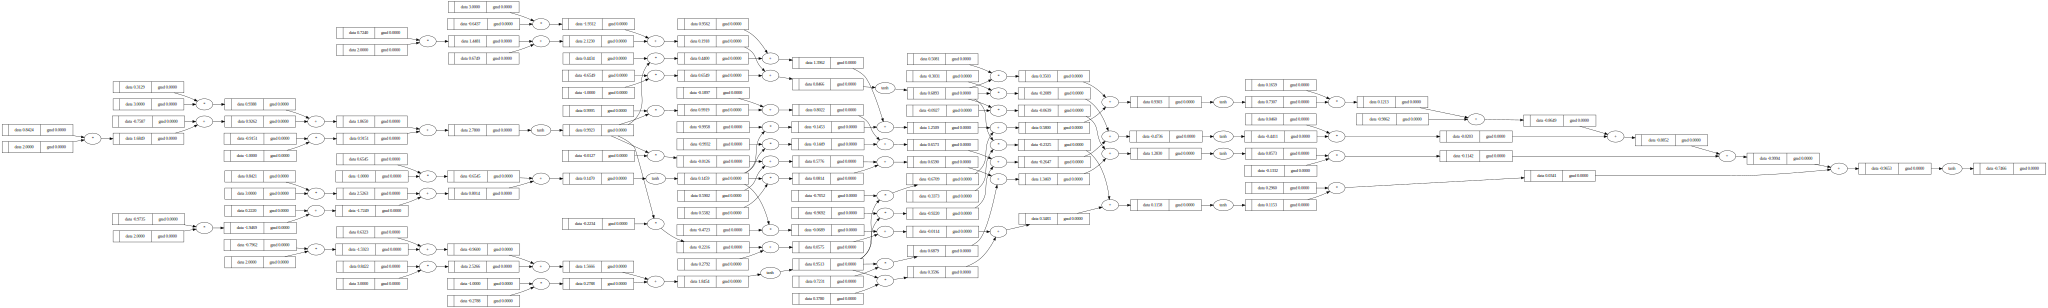

In [131]:
draw_dot(n(x))

In [132]:
x = xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.7466331240847136),
 Value(data=-0.6211090312392211),
 Value(data=-0.8198865180512939),
 Value(data=-0.6732391343608566)]

In [133]:
loss =sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

In [134]:
loss

Value(data=6.026455703494764)

In [294]:
loss.backward()

In [295]:
#draw_dot(loss)

In [296]:
for p in n.parameters():
    p.data += -0.01 * p.grad
    

In [297]:
#n.layers[0].neurons[0].w[0].data

In [298]:
x = xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
loss =sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.00012607767891372748)

In [299]:
ypred

[Value(data=0.9983300085700869),
 Value(data=-0.9894942496408187),
 Value(data=-0.9999995481391616),
 Value(data=0.9964058357405194)]

In [300]:
n.parameters()

[Value(data=0.7635350460187404),
 Value(data=-0.10418510549076689),
 Value(data=-1.2758802876159379),
 Value(data=-1.1019349810532408),
 Value(data=-1.728264718362675),
 Value(data=0.14972031389276427),
 Value(data=2.679518545682102),
 Value(data=0.5865132922277843),
 Value(data=-0.8345338313582047),
 Value(data=0.7513507727411736),
 Value(data=-1.0609794254463083),
 Value(data=0.42918795913888697),
 Value(data=0.24531375375801445),
 Value(data=-1.4001890964922525),
 Value(data=-0.7432621351700006),
 Value(data=0.10369407242608072),
 Value(data=1.8855662972573288),
 Value(data=-2.1595577106805712),
 Value(data=-1.5203640343666804),
 Value(data=1.3093111849001753),
 Value(data=-0.35720130060772287),
 Value(data=1.1273250094623513),
 Value(data=-1.0528099117677316),
 Value(data=-0.8507324224269068),
 Value(data=-0.19837083138291353),
 Value(data=-0.05144949640584573),
 Value(data=-0.08812104956823605),
 Value(data=0.8069697178971874),
 Value(data=1.6476999178504141),
 Value(data=-0.63295

In [311]:
n = MLP(3,[4,4,1])   # 3 INPUTS 4 HIDDEN LAYERS 4 HIDDEN LAYERS AND LASTLY ONE OUTPUTS

In [340]:
x = xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets




for k in range(20):

  #forward pass
  ypred = [n(x) for x in xs]
  loss =sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)



0 0.002658248298883645
1 0.0026467140517296714
2 0.0026352796853983222
3 0.0026239439056628885
4 0.002612705440594963
5 0.0026015630400856122
6 0.0025905154753789995
7 0.0025795615386177816
8 0.0025687000424002406
9 0.00255792981934841
10 0.002547249721687372
11 0.0025366586208349115
12 0.0025261554070016377
13 0.0025157389888008576
14 0.002505408292868298
15 0.0024951622634912145
16 0.002484999862246527
17 0.0024749200676479543
18 0.002464921874801666
19 0.0024550042950703564


In [341]:
ypred

[Value(data=0.9758102460106456),
 Value(data=-0.9777756696978612),
 Value(data=-0.9712324590157817),
 Value(data=0.9765827451363823)]

## example 

In [342]:
np.random.seed(1337)
random.seed(1337)

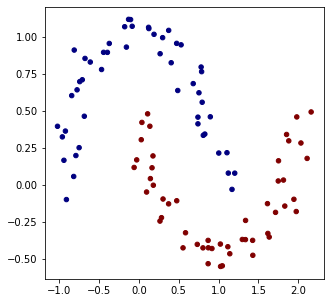

In [343]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [344]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [347]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=Value(data=0.7840043023159258)) 0.68


In [351]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    #model.zero_grad()
    for p in model.parameters():
        p.grad = 0.0
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss Value(data=0.7840043023159258), accuracy 68.0%
step 1 loss Value(data=0.5347049296619351), accuracy 73.0%
step 2 loss Value(data=0.4048546719046316), accuracy 83.0%
step 3 loss Value(data=0.33806543851635257), accuracy 86.0%
step 4 loss Value(data=0.2942149201529844), accuracy 88.0%
step 5 loss Value(data=0.2712885319238902), accuracy 90.0%
step 6 loss Value(data=0.2556652938440778), accuracy 90.0%
step 7 loss Value(data=0.24339405910331308), accuracy 91.0%
step 8 loss Value(data=0.2329486383718355), accuracy 91.0%
step 9 loss Value(data=0.22351581181269675), accuracy 91.0%
step 10 loss Value(data=0.21455760126897733), accuracy 91.0%
step 11 loss Value(data=0.20576594323344485), accuracy 91.0%
step 12 loss Value(data=0.1969193480251714), accuracy 92.0%
step 13 loss Value(data=0.18790113340865408), accuracy 93.0%
step 14 loss Value(data=0.1786414055557646), accuracy 94.0%
step 15 loss Value(data=0.1692426296252268), accuracy 94.0%
step 16 loss Value(data=0.15986259588078486)

(-1.548639298268643, 1.951360701731357)

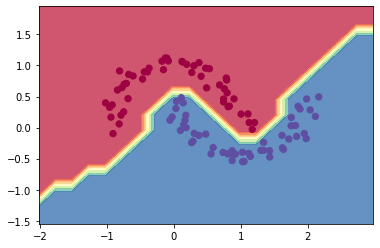

In [352]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())